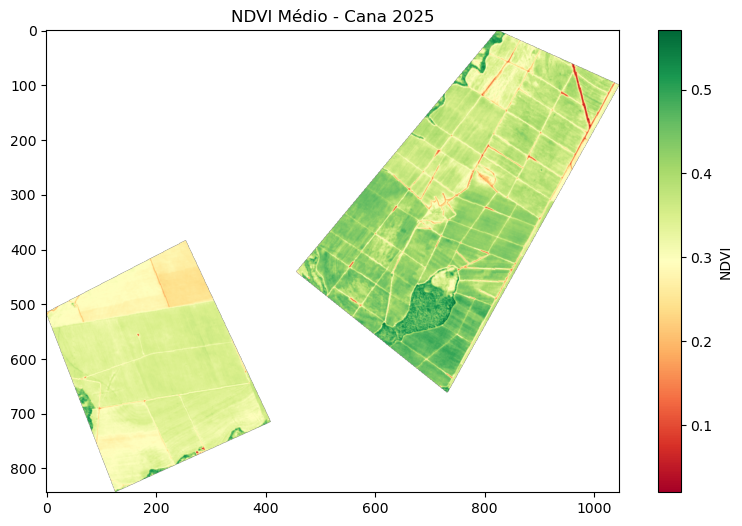

In [1]:
import rasterio
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

with rasterio.open("NDVI_Medio_Cana_2025_Fazenda.tif") as src:
    ndvi = src.read(1)
    plt.imshow(ndvi, cmap="RdYlGn")
    plt.colorbar(label="NDVI")
    plt.title("NDVI Médio - Cana 2025")
    plt.show()


In [ ]:
#### PREVISÃO DE PRODUTIVIDADE 2026

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ======================================================
# 📂 LEITURA DOS DADOS
# ======================================================
df_indices = pd.read_csv("Indices_GEE_Talhoes_2019_2025.csv")   # NDVI/EVI/NDWI
df_ciclos  = pd.read_csv("ciclos_2019_2025.csv")               # manejo + produtividade
df_clima   = pd.read_csv("clima_2019_2025.csv")                # chuva + ET0

# ======================================================
# 🧩 PRÉ-PROCESSAMENTO E MERGE
# ======================================================
df_ciclos['ano'] = pd.to_datetime(df_ciclos['data_colheita'], errors='coerce').dt.year
df_indices['ano'] = df_indices['ano'].astype(int)

# Combinar as bases
df = (
    df_ciclos
    .merge(df_clima, on=['id_talhao','id_ciclo'], how='left')
    .merge(df_indices, on=['id_talhao','ano'], how='left')
)

# Remover colunas irrelevantes
cols_drop = [
    'fazenda','setor','variedade','data_plantio','data_brotacao','data_colheita',
    'id_ciclo'
]
df = df.drop(columns=cols_drop, errors='ignore')

# Remover linhas sem dados numéricos
df = df.dropna()

print(f"✅ Dataset final: {df.shape[0]} linhas e {df.shape[1]} colunas")

# ======================================================
# ⚙️ ENCODING E SELEÇÃO DE VARIÁVEIS
# ======================================================
y = df['tch_t_ha']  # variável-alvo
X = df.drop(columns=['tch_t_ha', 'atr_kg_t', 'umidade_pct'], errors='ignore')

# Converter variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

print(f"🔹 Total de variáveis após encoding: {X.shape[1]}")

# ======================================================
# 🌿 FUNÇÃO DE AUMENTO SINTÉTICO REALISTA (corrigida)
# ======================================================
def augment_numeric_data(X, y, n_aug=3, noise_level=0.02):
    """
    Cria versões sintéticas dos dados com pequenas variações gaussianas.
    - n_aug: número de cópias sintéticas por observação
    - noise_level: intensidade do ruído (0.02 = 2% do desvio padrão)
    """
    # Separar numéricas e categóricas
    X_num = X.select_dtypes(include=[np.number]).reset_index(drop=True)
    X_cat = X.select_dtypes(exclude=[np.number]).reset_index(drop=True)
    y = y.reset_index(drop=True)

    X_aug_list = [X]
    y_aug_list = [y]

    for i in range(n_aug):
        # Gera ruído proporcional ao desvio padrão de cada coluna
        stds = X_num.std().replace(0, 1e-6)  # evita divisão por zero
        noise = np.random.normal(0, noise_level, X_num.shape)
        X_noisy = X_num + noise * stds.values

        # Recombinar numéricas + categóricas (mantendo mesmo número de linhas)
        X_synth = pd.concat([X_noisy, X_cat], axis=1)
        X_aug_list.append(X_synth)
        y_aug_list.append(y.copy())

    # Concatenar tudo
    X_new = pd.concat(X_aug_list, axis=0).reset_index(drop=True)
    y_new = pd.concat(y_aug_list, axis=0).reset_index(drop=True)

    print(f"🌿 Dados aumentados sinteticamente: {len(X_new)} amostras (x{n_aug+1})")
    return X_new, y_new

# ======================================================
# 🚀 TREINAMENTO DO MODELO
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Aumentar o conjunto de treino de forma realista
X_train_aug, y_train_aug = augment_numeric_data(X_train, y_train, n_aug=3, noise_level=0.02)

model = RandomForestRegressor(
    n_estimators=10000,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_aug, y_train_aug)

# ======================================================
# 📈 AVALIAÇÃO DO MODELO
# ======================================================
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n📊 Desempenho do modelo:\n   R² = {r2:.3f}\n   MAE = {mae:.2f} t/ha")

# ======================================================
# 🔁 VALIDAÇÃO CRUZADA (5-fold)
# ======================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(f"🔁 R² médio cross-val: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ======================================================
# 🔍 IMPORTÂNCIA DAS VARIÁVEIS
# ======================================================
importances = pd.DataFrame({
    'Variável': X.columns,
    'Importância': model.feature_importances_
}).sort_values('Importância', ascending=False)

# plt.figure(figsize=(10,6))
# sns.barplot(x='Importância', y='Variável', data=importances.head(15))
# plt.title('🔎 Principais Variáveis que Influenciam a Produtividade (TCH)')
# plt.tight_layout()
# plt.show()

# ======================================================
# 🔮 PREVISÃO FUTURA
# ======================================================
df_pred = df.copy()
df_pred['tch_pred'] = model.predict(X)

print("\nExemplo de previsões:")
display(df_pred[['id_talhao','ano','tch_t_ha','tch_pred']].head(10))

# ======================================================
# 💾 EXPORTAÇÃO
# ======================================================
df_pred.to_csv("predicoes_produtividade_talhoes.csv", index=False)
print("\n💾 Resultados salvos em: predicoes_produtividade_talhoes.csv")

# ======================================================
# 💾 SALVAR MODELO E BASE DE TREINO
# ======================================================
joblib.dump(model, "modelo_produtividade_tch.pkl")
X.to_csv("X_base_treino.csv", index=False)
print("\n💾 Modelo salvo como: modelo_produtividade_tch.pkl")


✅ Dataset final: 12 linhas e 37 colunas
🔹 Total de variáveis após encoding: 52
🌿 Dados aumentados sinteticamente: 36 amostras (x4)

📊 Desempenho do modelo:
   R² = 0.793
   MAE = 4.28 t/ha
🔁 R² médio cross-val: 0.521 ± 0.179

Exemplo de previsões:


,id_talhao,ano,tch_t_ha,tch_pred
0,T001,2020,80.1,77.03342
1,T001,2021,74.5,74.42837
2,T001,2022,65.2,65.22969
3,T001,2023,59.5,59.51869
4,T001,2024,52.6,52.74955
5,T001,2025,49.2,49.22538
7,T002,2020,87.3,87.08350
8,T002,2021,74.5,74.51084
9,T002,2022,66.7,66.60801
10,T002,2023,61.2,56.75257



💾 Resultados salvos em: predicoes_produtividade_talhoes.csv

💾 Modelo salvo como: modelo_produtividade_tch.pkl


#### PREVISÃO DE PRODUTIVIDADE 2026

In [24]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Carregar modelo e base de treino
model = joblib.load("modelo_produtividade_tch.pkl")
X_treino = pd.read_csv("X_base_treino.csv")
cols_modelo = X_treino.columns

# Carregar projeções dos índices espectrais
proj_gee = pd.read_csv("indices_projetados_2026.csv")

# simulando dados para Dois talhoes no ano que vem
df_pred_2026 = pd.DataFrame({
    "id_talhao": ["T001", "T002"],
    "ano": [2026, 2026],
    "numero_cortes": [0, 0],
    "tipo_ciclo": ["planta", "planta"],
    "calcario_t_ha": [1.37, 0.82],
    "gesso_t_ha": [0.56, 0.27],
    "p2o5_kg_ha": [63, 64],
    "vinaca_m3_ha": [90, 90],
    "inseticida": ["nao", "nao"],
    "operacoes_herbicida": [1, 1],
    "irrigacao_mm_total": [108.71, 232.49],
    "et0_soma_ciclo_mm": [63, 64],
    "chuva_soma_ciclo_mm": [90, 90],
    "tch_t_ha": [80.1, 87.3],
    "atr_kg_t": [126.9, 126.1],
    "umidade_pct": [80.2, 79.6],
    "NDVI": proj_gee["NDVI"].values[0],
    "NDWI": proj_gee["NDWI"].values[0],
    "EVI": proj_gee["EVI"].values[0]
})


# Encoding igual ao modelo
X_pred = pd.get_dummies(df_pred_2026, drop_first=True)
X_pred = X_pred.reindex(columns=cols_modelo, fill_value=0)

# Prever TCH
df_pred_2026["TCH_previsto"] = model.predict(X_pred)

print("🔎 Estimativas de Produtividade (1º Corte 2026):")
display(df_pred_2026[["id_talhao", "TCH_previsto"]])

# Exportar resultados
df_pred_2026.to_csv("previsao_produtividade_2026.csv", index=False)
print("\n💾 Resultados salvos em: previsao_produtividade_2026.csv")


🔎 Estimativas de Produtividade (1º Corte 2026):


,id_talhao,TCH_previsto
0,T001,61.03331
1,T002,61.57282



💾 Resultados salvos em: previsao_produtividade_2026.csv


In [21]:
### versao sem os dados de satelites.

In [23]:
# ======================================================
# 📦 IMPORTAÇÕES
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ======================================================
# 📂 LEITURA DOS DADOS
# ======================================================
df_indices = pd.read_csv("Indices_GEE_Talhoes_2019_2025.csv")   # NDVI/EVI/NDWI
df_ciclos  = pd.read_csv("ciclos_2019_2025.csv")               # manejo + produtividade
df_clima   = pd.read_csv("clima_2019_2025.csv")                # chuva + ET0

# ======================================================
# 🧩 PRÉ-PROCESSAMENTO E MERGE (sem dados de satélite)
# ======================================================
df_ciclos['ano'] = pd.to_datetime(df_ciclos['data_colheita'], errors='coerce').dt.year
df_indices['ano'] = df_indices['ano'].astype(int)

# ❌ Não vamos usar NDVI, NDWI, EVI — portanto, não fazemos merge com df_indices
df = (
    df_ciclos
    .merge(df_clima, on=['id_talhao','id_ciclo'], how='left')
)

# Remover colunas irrelevantes
cols_drop = [
    'fazenda','setor','variedade','data_plantio','data_brotacao','data_colheita',
    'id_ciclo'
]
df = df.drop(columns=cols_drop, errors='ignore')

# Remover linhas sem dados numéricos
df = df.dropna()

print(f"✅ Dataset final (sem satélite): {df.shape[0]} linhas e {df.shape[1]} colunas")

# ======================================================
# ⚙️ ENCODING E SELEÇÃO DE VARIÁVEIS
# ======================================================
y = df['tch_t_ha']  # variável-alvo
X = df.drop(columns=['tch_t_ha', 'atr_kg_t', 'umidade_pct'], errors='ignore')

# Converter variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

print(f"🔹 Total de variáveis após encoding: {X.shape[1]} (sem NDVI/EVI/NDWI)")

# ======================================================
# 🌿 FUNÇÃO DE AUMENTO SINTÉTICO REALISTA (corrigida)
# ======================================================
def augment_numeric_data(X, y, n_aug=3, noise_level=0.02):
    """
    Cria versões sintéticas dos dados com pequenas variações gaussianas.
    - n_aug: número de cópias sintéticas por observação
    - noise_level: intensidade do ruído (0.02 = 2% do desvio padrão)
    """
    # Separar numéricas e categóricas
    X_num = X.select_dtypes(include=[np.number]).reset_index(drop=True)
    X_cat = X.select_dtypes(exclude=[np.number]).reset_index(drop=True)
    y = y.reset_index(drop=True)

    X_aug_list = [X]
    y_aug_list = [y]

    for i in range(n_aug):
        # Gera ruído proporcional ao desvio padrão de cada coluna
        stds = X_num.std().replace(0, 1e-6)  # evita divisão por zero
        noise = np.random.normal(0, noise_level, X_num.shape)
        X_noisy = X_num + noise * stds.values

        # Recombinar numéricas + categóricas (mantendo mesmo número de linhas)
        X_synth = pd.concat([X_noisy, X_cat], axis=1)
        X_aug_list.append(X_synth)
        y_aug_list.append(y.copy())

    # Concatenar tudo
    X_new = pd.concat(X_aug_list, axis=0).reset_index(drop=True)
    y_new = pd.concat(y_aug_list, axis=0).reset_index(drop=True)

    print(f"🌿 Dados aumentados sinteticamente: {len(X_new)} amostras (x{n_aug+1})")
    return X_new, y_new

# ======================================================
# 🚀 TREINAMENTO DO MODELO
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Aumentar o conjunto de treino de forma realista
X_train_aug, y_train_aug = augment_numeric_data(X_train, y_train, n_aug=3, noise_level=0.02)

model = RandomForestRegressor(
    n_estimators=10000,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_aug, y_train_aug)

# ======================================================
# 📈 AVALIAÇÃO DO MODELO
# ======================================================
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n📊 Desempenho do modelo (sem satélite):\n   R² = {r2:.3f}\n   MAE = {mae:.2f} t/ha")

# ======================================================
# 🔁 VALIDAÇÃO CRUZADA (5-fold)
# ======================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(f"🔁 R² médio cross-val: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ======================================================
# 🔍 IMPORTÂNCIA DAS VARIÁVEIS
# ======================================================
importances = pd.DataFrame({
    'Variável': X.columns,
    'Importância': model.feature_importances_
}).sort_values('Importância', ascending=False)

# plt.figure(figsize=(10,6))
# sns.barplot(x='Importância', y='Variável', data=importances.head(15))
# plt.title('🔎 Principais Variáveis que Influenciam a Produtividade (sem NDVI/EVI/NDWI)')
# plt.tight_layout()
# plt.show()

# ======================================================
# 🔮 PREVISÃO FUTURA
# ======================================================
df_pred = df.copy()
df_pred['tch_pred'] = model.predict(X)

print("\nExemplo de previsões:")
display(df_pred[['id_talhao','ano','tch_t_ha','tch_pred']].head(10))

# ======================================================
# 💾 EXPORTAÇÃO
# ======================================================
df_pred.to_csv("predicoes_produtividade_sem_satellite.csv", index=False)
print("\n💾 Resultados salvos em: predicoes_produtividade_sem_satellite.csv")

# ======================================================
# 💾 SALVAR MODELO E BASE DE TREINO
# ======================================================
joblib.dump(model, "modelo_produtividade_sem_satellite.pkl")
X.to_csv("X_base_treino_sem_satellite.csv", index=False)
print("\n💾 Modelo salvo como: modelo_produtividade_sem_satellite.pkl")


✅ Dataset final (sem satélite): 14 linhas e 23 colunas
🔹 Total de variáveis após encoding: 30 (sem NDVI/EVI/NDWI)
🌿 Dados aumentados sinteticamente: 40 amostras (x4)

📊 Desempenho do modelo (sem satélite):
   R² = 0.881
   MAE = 3.17 t/ha
🔁 R² médio cross-val: 0.467 ± 0.374

Exemplo de previsões:


,id_talhao,ano,tch_t_ha,tch_pred
0,T001,2020,80.1,79.53530
1,T001,2021,74.5,74.44045
2,T001,2022,65.2,65.26905
3,T001,2023,59.5,59.52719
4,T001,2024,52.6,52.65929
5,T001,2025,49.2,49.22661
6,T001,2026,43.7,43.71107
7,T002,2020,87.3,86.97752
8,T002,2021,74.5,74.56472
9,T002,2022,66.7,63.82774



💾 Resultados salvos em: predicoes_produtividade_sem_satellite.csv

💾 Modelo salvo como: modelo_produtividade_sem_satellite.pkl
